In [6]:
import json
import os
import sys

import matplotlib.pyplot as plt
import numpy as np
import torch
from omegaconf import OmegaConf
from torch.utils.data import DataLoader
from utils import data_process, helper

sys.path.append('../')

from get_mlp_mappings import ComputeMLPContributions
from image_vps_datasets import (single_image_cityscape_vps_dataset,
                                single_image_vipseg_dataset)
from model_all_analysis import ffn, lightning_model

In [8]:
def load_cfg(model_ckpt_dir, dataset_name, vidname):
    
    if dataset_name == "cityscapes":

        exp_config_path = os.path.join(model_ckpt_dir, 'exp_config.yaml')
        
        cfg = OmegaConf.load(exp_config_path)
        
        cfg.data.cityscapes_vps_root = "../data/cityscapes_vps"
        cfg.data.split = "val"
        cfg.data.panoptic_video_mask_dir = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "panoptic_video")
        cfg.data.panoptic_inst_mask_dir = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "panoptic_inst")
        
        cfg.data.vidname = vidname
        # We will work with the first annotated frame in the given video
        cfg.data.frame_num_in_video = 0
        
        cfg.data.data_path = os.path.join(cfg.data.cityscapes_vps_root, cfg.data.split, "img_all")
        cfg.data.anno_path = '../data/cityscapes_vps/panoptic_gt_val_city_vps.json'
        
        with open(cfg.data.anno_path, 'r') as f:
            panoptic_gt_val_city_vps = json.load(f)
                    
        panoptic_categories = panoptic_gt_val_city_vps['categories']   
        
        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}

    elif dataset_name == "vipseg":
        exp_config_path = os.path.join(model_ckpt_dir, 'exp_config.yaml')
        
        
        cfg = OmegaConf.load(exp_config_path)
        
        cfg.data.VIPSeg_720P_root = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P'
        cfg.data.panomasks_dir = os.path.join(cfg.data.VIPSeg_720P_root, "panomasks")
        cfg.data.panomasksRGB_dir = os.path.join(cfg.data.VIPSeg_720P_root, "panomasksRGB")
        
        cfg.data.vidname = vidname
        # We will work with the first annotated frame in the given video
        cfg.data.frame_num_in_video = 0
        
        cfg.data.data_path = data_path = os.path.join(cfg.data.VIPSeg_720P_root, "images")
        cfg.data.anno_path = '../data/VIPSeg-Dataset/VIPSeg/VIPSeg_720P/panoptic_gt_VIPSeg.json'
        
        # Crop for VIPSeg to match NeRV
        cfg.data.crop=[640,1280]
        
        with open(cfg.data.anno_path, 'r') as f:
            panoptic_gt_VIPSeg = json.load(f)
                    
        panoptic_categories = panoptic_gt_VIPSeg['categories']
        
        categories = panoptic_categories
        categories.append(
            {'id': -1, 'name': 'other', 'supercategory': '', 'color':None}
        )
        categories_dict = {el['id']: el for el in categories}
        
    return cfg, categories_dict


def load_model(cfg):
    save_dir = cfg.logging.checkpoint.logdir
    ckpt_path = helper.find_ckpt(save_dir)
    print(f'Loading checkpoint from {ckpt_path}')

    checkpoint = torch.load(ckpt_path)

    # Load checkpoint into this wrapper model cause that is what is stored in disk :)
    model = lightning_model(cfg, ffn(cfg))
    model.load_state_dict(checkpoint['state_dict'])
    ffn_model = model.model
    
    return ffn_model.cuda()

def get_loader(cfg,dataset_name,val=False):
    # use the dataloader which returns image along with annotations
    if dataset_name == "cityscapes":
        img_dataset = single_image_cityscape_vps_dataset(cfg)
    else:
        img_dataset = single_image_vipseg_dataset(cfg)
    #create torch dataset for one image.
    loader = DataLoader(img_dataset, batch_size=1, shuffle = False ,num_workers=0)
    return loader

In [9]:
# Multiple videos
dataset_names = ['cityscapes', 'vipseg']
vidnames = {
    'cityscapes': ['0005', '0175'],
    'vipseg': ['12_n-ytHkMceew', '26_cblDl5vCZnw']
}

vid_data_folder_name = {
    "cityscapes": "Cityscapes_VPS_models",
    "vipseg": "VIPSeg_models"
}


cfg_dict = {}
dataloader_dict = {}
weights_dict = {}
ffn_models_dict = {}
categories_dicts = {}

In [ ]:
for dataset_name in dataset_names:
    weights_dict[dataset_name] = {}
    cfg_dict[dataset_name] = {}
    ffn_models_dict[dataset_name] = {}
    categories_dicts[dataset_name] = {}

    for vidname in vidnames[dataset_name]:
        vid_data_folder = vid_data_folder_name[dataset_name]
        weights_dict[dataset_name][vidname] = f'output/{vid_data_folder}/{vidname}/{vidname}_framenum_0_128_256'
        
        cfg, categories_dict = load_cfg(weights_dict[dataset_name][vidname], dataset_name, vidname)
        cfg_dict[dataset_name][vidname] = cfg
        categories_dicts[dataset_name][vidname] = categories_dict
        
        
        ffn_models_dict[dataset_name][vidname] = load_model(cfg)
        
for dataset_name in dataset_names:
    dataloader_dict[dataset_name] = {}
    
    for vidname in vidnames[dataset_name]:
        single_image_dataloader = get_loader(cfg_dict[dataset_name][vidname], dataset_name)
        
        dataloader_dict[dataset_name][vidname] = single_image_dataloader

# Done with creating multiple models and dataloaders!

In [11]:
def compute_inference_results(single_image_dataloader, ffn_model, cfg, is_lab=False):
    with torch.no_grad():
        batch = next(iter(single_image_dataloader))

    data = batch['data'].cuda()
    N,C,H,W = data.shape
    annotations = convert_tensor_annotations_to_numpy(batch['annotations'])
    annotations = add_other_annotation(annotations)

    features = batch['features'].squeeze().cuda()
    features_shape = batch['features_shape'].squeeze().tolist()
    reshape = True

    proc = data_process.DataProcessor(cfg.data, device='cpu')
    x = batch['data']
    coords = proc.get_coordinates(data_shape=features_shape,patch_shape=cfg.data.patch_shape,\
                                    split=cfg.data.coord_split,normalize_range=cfg.data.coord_normalize_range)
    coords = coords.to(x).cuda()

    # Create a dictionary to store the intermediate decoder_results from each seeded model, over time.
    inference_results = {}
    kwargs = {}
    with torch.no_grad():
        out = ffn_model(coords, img=data)
        pred = out['predicted']
        intermediate_results = out["intermediate_results"]
        
        psnr = helper.get_clamped_psnr(features,pred)
        
        if reshape:
            # This reshapes the prediction into an image
            pred = proc.process_outputs(
                pred,input_img_shape=batch['data_shape'].squeeze().tolist(),\
                features_shape=features_shape,\
                patch_shape=cfg.data.patch_shape)

    pred = pred.squeeze().clamp(0,1)

    inference_results = {
        "data": batch["data"],
        "pred": pred,
        "annotations": annotations,
        "img_hw": (H,W),
        "intermediate_results": intermediate_results
    }
    
    return inference_results

In [26]:
# Contribution map vs intensity image

from scipy.ndimage import sobel
from skimage import color
from skimage import io

def plot_heatmap_vs_intensity(inference_results, ffn_model):
    gt_img = inference_results["data"][0]
    pred = inference_results["pred"]
    intermediate_results = inference_results["intermediate_results"]
    (H,W) = inference_results["img_hw"]

    # Get model contributions
    compute_contrib_obj = ComputeMLPContributions(
        ffn_model, intermediate_results, (H,W)
    )

    layer_1_output_contrib, layer_2_output_contrib, layer_3_output_contrib, _, _, _ = compute_contrib_obj.compute_all_layer_mappings()

    layer_1_abs_heatmap = torch.sum(torch.abs(layer_1_output_contrib), dim=0)
    layer_2_abs_heatmap = torch.sum(torch.abs(layer_2_output_contrib), dim=0)
    layer_3_abs_heatmap = torch.sum(torch.abs(layer_3_output_contrib), dim=0)
    
    # Sum across RGB channels
    rgb_intensity_image = gt_img.sum(dim=0).cpu()


    fig, axs = plt.subplots(2, 4, figsize=(20, 5), tight_layout=True)
    
    axs[0][0].imshow(rgb_intensity_image, cmap='magma')
    axs[0][0].set_title('Total RGB Intensity Image')
    
    axs[0][1].imshow(layer_3_abs_heatmap.cpu(), cmap='magma')
    axs[0][1].set_title('Layer 3 Contribution Heatmap')
    
    axs[0][2].imshow(layer_2_abs_heatmap.cpu(), cmap='magma')
    axs[0][2].set_title('Layer 2 Contribution Heatmap')

    axs[0][3].imshow(layer_1_abs_heatmap.cpu(), cmap='magma')
    axs[0][3].set_title('Layer 1 Contribution Heatmap')
    
    
    
    # To show difference of (contributions - intensity), first normalize each then subtract
    normalized_intensity_image = (rgb_intensity_image - rgb_intensity_image.min()) / (rgb_intensity_image.max() - rgb_intensity_image.min())
    normalized_layer_1_contrib_heatmap = (layer_1_abs_heatmap - layer_1_abs_heatmap.min()) / (layer_1_abs_heatmap.max() - layer_1_abs_heatmap.min())
    normalized_layer_2_contrib_heatmap = (layer_2_abs_heatmap - layer_2_abs_heatmap.min()) / (layer_2_abs_heatmap.max() - layer_2_abs_heatmap.min())
    normalized_layer_3_contrib_heatmap = (layer_3_abs_heatmap - layer_3_abs_heatmap.min()) / (layer_3_abs_heatmap.max() - layer_3_abs_heatmap.min())

    # Don't take absolutes, let's use negatives for diverging for plot
    layer_1_intensity_contrib_diff = normalized_layer_1_contrib_heatmap - normalized_intensity_image
    layer_2_intensity_contrib_diff = normalized_layer_2_contrib_heatmap - normalized_intensity_image
    layer_3_intensity_contrib_diff = normalized_layer_3_contrib_heatmap - normalized_intensity_image

    # leave axs[1][0] empty or put Sobel filter
    gray_image = color.rgb2gray(gt_img.cpu().permute(1,2,0))
    sobel_horizontal = sobel(gray_image, axis=0)
    sobel_vertical = sobel(gray_image, axis=1)
    sobel_combined = np.sqrt(sobel_horizontal**2 + sobel_vertical**2)
    axs[1][0].imshow(sobel_combined, cmap='magma')
    axs[1][0].set_title('Edge Map (Sobel Filter)')

    # Plot layer 3 to layer 1 (like head .. blk 3)
    
    axs[1][1].imshow(layer_3_intensity_contrib_diff.cpu(), cmap='magma')
    axs[1][1].set_title('Layer 3 Contribution - Intensity Difference')
    
    axs[1][2].imshow(layer_2_intensity_contrib_diff.cpu(), cmap='magma')
    axs[1][2].set_title('Layer 2 Contribution - Intensity Difference')
    
    axs[1][3].imshow(layer_1_intensity_contrib_diff.cpu(), cmap='magma')
    axs[1][3].set_title('Layer 1 Contribution - Intensity Difference')

    for ax in axs.flat:
        ax.axis('off')

    fig.suptitle(f"Contribution Heatmaps vs Total Intensity Image", y=0.95)
    
    intensity_vs_heatmap_dict = {
        "rgb_intensity": rgb_intensity_image,
        "heatmaps" : {
            "layer_1": layer_1_abs_heatmap.cpu(),
            "layer_2": layer_2_abs_heatmap.cpu(),
            "layer_3": layer_3_abs_heatmap.cpu(),
        },
        "diffs_after_normalize": {
            "layer_1": layer_1_intensity_contrib_diff.cpu(),
            "layer_2": layer_2_intensity_contrib_diff.cpu(),
            "layer_3": layer_3_intensity_contrib_diff.cpu(),
        },
        "edge_map": sobel_combined
    }
    
    return intensity_vs_heatmap_dict

# plt.colorbar(shrink=0.6)

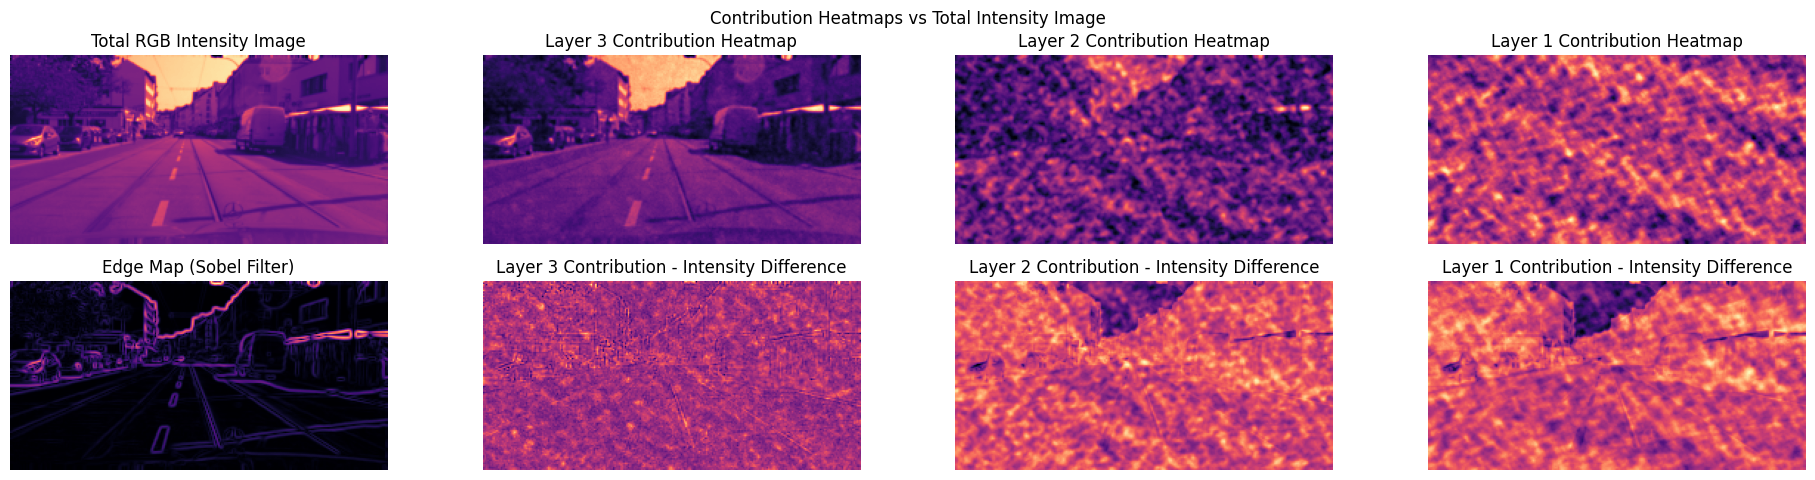

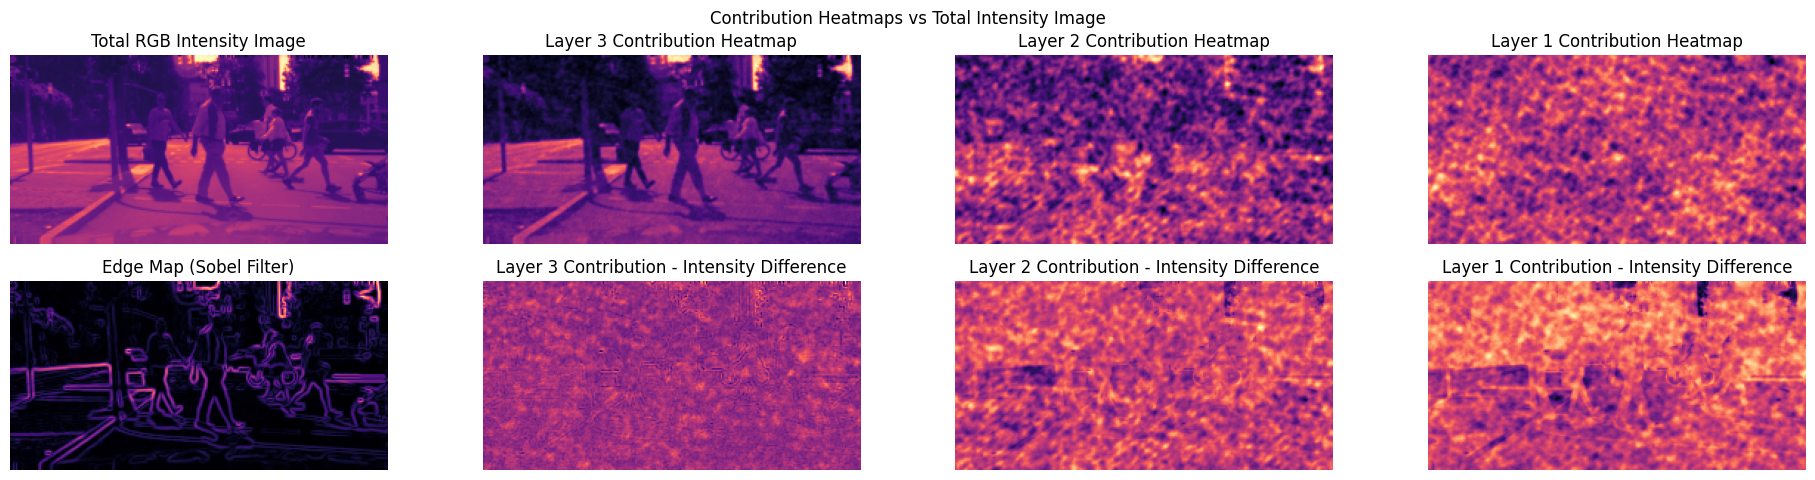

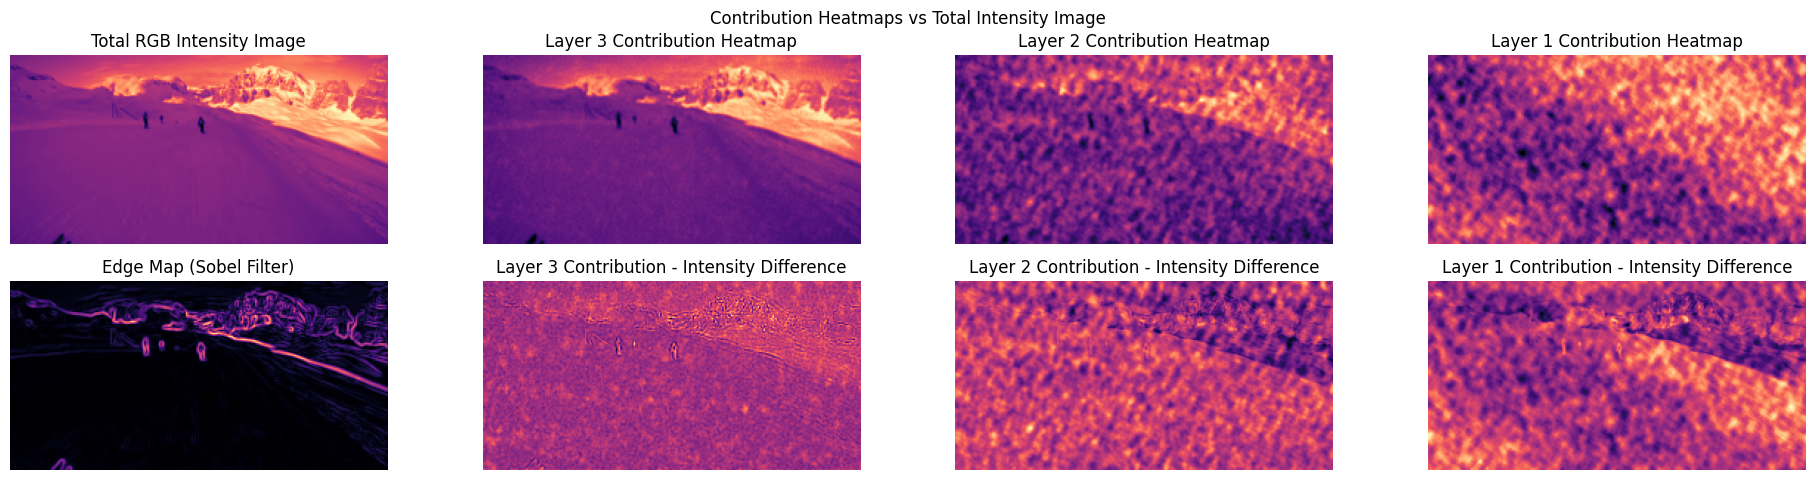

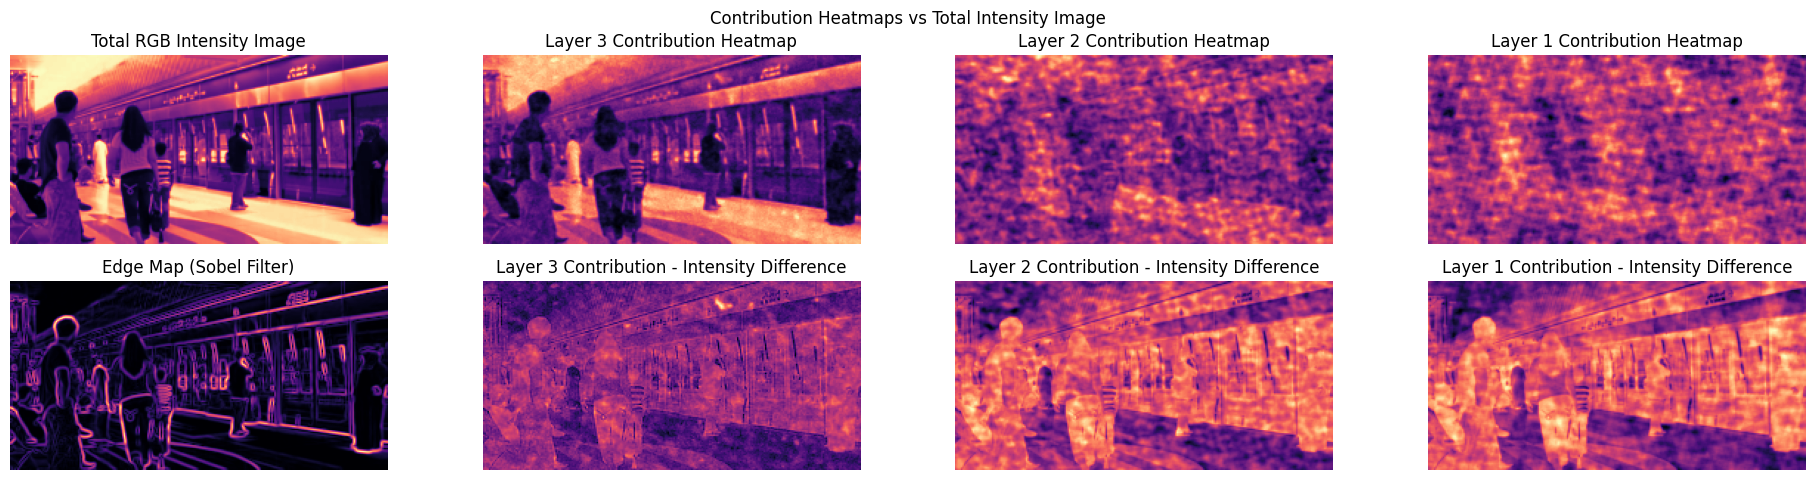

In [19]:
per_vid_intensity_vs_heatmap_dict = {}

for dataset_name in dataset_names:
    for vidname in vidnames[dataset_name]:
        single_image_dataloader = dataloader_dict[dataset_name][vidname]
        ffn_model = ffn_models_dict[dataset_name][vidname]
        # categories_dict = categories_dicts[dataset_name][vidname]
        cfg = cfg_dict[dataset_name][vidname]

        inference_results = compute_inference_results(single_image_dataloader, ffn_model, cfg)
        per_vid_intensity_vs_heatmap_dict[vidname] = plot_heatmap_vs_intensity(inference_results, ffn_model)



# Dump raw values for final plotting

In [20]:
import pickle

# Save the per_vid_num_pixels_with_meaningful_contrib and per_vid_num_kernels_with_meaningful_contrib to files

save_dir = '../plotting_source_data/MLP/A-contribution_vs_intensity'
os.makedirs(save_dir, exist_ok=True)


with open(os.path.join(save_dir, f"per_vid_intensity_vs_heatmap_dict.pkl"), 'wb') as f:
    pickle.dump(per_vid_intensity_vs_heatmap_dict, f)